# Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

We will make a really simple LSTM with Keras to predict the stock price in the Chinese stock.

In [4]:
import tensorflow as tf
from tensorflow import keras


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM


In [6]:
import time
import math
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

## Import Data

I have introduced how we get this dataset both in README.md and in another notebook.

In [7]:
df = pd.read_csv('/content/ummmm.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


## Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize your training data before you feed data into your model. "Having different features with widely different scales fed to your model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation." Read [here](http://stackoverflow.com/a/43526354/6670143) for more detailed explanation.

In [8]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape

    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))

    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)

    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))

    return X_train, X_test

Split the data to X_train, y_train, X_test, y_test

In [9]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]

    train, result = standard_scaler(train, result)

    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

## Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [10]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [11]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (45, 20, 6)
y_train (45,)
X_test (5, 20, 6)
y_test (5,)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, input_shape=input_shape))
    model.add(Dense(units=1))  # Add a Dense layer, adjust units as needed
    return model

# Assuming X_train is your training data
model = build_model((X_train.shape[1], X_train.shape[2]))


## Training the Network

You can play with the hyperparameters here. The training process can take a significant time if you are using a average GPU or CPU(worse!).

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Assuming you have already defined your model using the build_model function

# Compile the model
model.compile(optimizer=Adam(), loss='mse')  # Use appropriate optimizer and loss function

# Fit the model
history = model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=5,
    validation_split=0.1,
    verbose=1
)


Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 1.2346 - val_loss: 0.1935
Epoch 2/5
1/1 [==============================] - 0s 50ms/step - loss: 1.0668 - val_loss: 0.3448
Epoch 3/5
1/1 [==============================] - 0s 49ms/step - loss: 0.9234 - val_loss: 0.5434
Epoch 4/5
1/1 [==============================] - 0s 58ms/step - loss: 0.8031 - val_loss: 0.7867
Epoch 5/5
1/1 [==============================] - 0s 48ms/step - loss: 0.7048 - val_loss: 1.0701


In [28]:
import math

# Assuming you have already compiled and trained your model

# Evaluate the model on the training data
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))

# Evaluate the model on the test data
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))


Train Score: 0.68 MSE (0.82 RMSE)
Test Score: 0.40 MSE (0.63 RMSE)


## Visualize the Prediction

In [29]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

1/1 [==============================] - 1s 1s/step


In [ ]:
# TODO: Scale it back

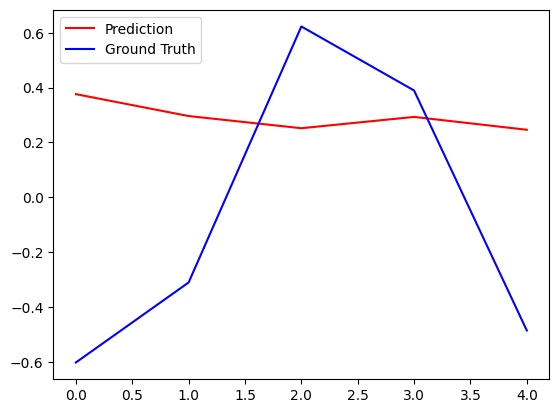

In [31]:
# if using within a jupyter notebook
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()